# Train and Evaluate a Machine Learning Model

In this I will perform empirical comparison of the results of a ten-fold cross validated model with a fully trained model.


### Dataset
* Dataset acquired from [KEEL](http://sci2s.ugr.es/keel/dataset.php?cod=105), an excellent resource for finding 'toy' datasets (and a few more serious ones).
    * A description of the dataset is provided at the above link -
    * Excerpt: 
    *The aim of this dataset is to distinguish between nasal (class 0) and oral sounds (class 1).
    The class distribution is 3,818 samples in class 0 and 1,586 samples in class 1.
    The phonemes are transcribed as follows: sh as in she, dcl as in dark, iy as the vowel in she, aa as the vowel in dark, and ao as the first vowel in water.*
    


## Import libraries and data

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib as jb

# locate dataset
DATASET = '/dsa/data/all_datasets/phoneme.csv'  # phoneme classification dataset
assert os.path.exists(DATASET)  # check if the file actually exists

## Constructing DataFrame from raw dataset


In [2]:
# read_table() is like read_csv(), but generalized for delimited file formats
# and calling .sample() with a fraction of 1 shuffles the data
dataset = pd.read_table(DATASET, sep=',', engine='c', header=0).sample(frac=1)

# verify dataset shape
print("Dataset shape: ", dataset.shape)
print(dataset.head())

Dataset shape:  (5404, 6)
         Aa     Ao    Dcl     Iy     Sh  Class
5206  0.312  0.862  1.637 -0.686 -0.423      0
2707  3.516 -0.361  0.173  0.084  0.069      0
3581  0.618  2.662  1.031  0.367  0.000      0
4281  0.873  2.740  0.827 -0.275 -0.149      0
1207  2.331  0.651 -0.107  0.128 -0.052      0


## Splitting data into training and test sets

In [3]:
# extract target data from primary data frame
X = dataset.iloc[:, 0:5]  # iloc is used here for numeric indexing
y = dataset.loc[:, "Class"]  # loc can be used for label-based indexing

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training shapes (X, y): ", X_train.shape, y_train.shape)
print("Testing shapes (X, y): ", X_test.shape, y_test.shape)

Training shapes (X, y):  (4323, 5) (4323,)
Testing shapes (X, y):  (1081, 5) (1081,)


## Constructing the classifier and running automated cross-validation

In [4]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

scores = cross_val_score(classifier, X, y, cv=5)

print(scores)

[ 0.75231054  0.77520814  0.7613321   0.7462963   0.76296296]


## Training the classifier and pickling to disk

In [5]:
fitted = classifier.fit(X_train, y_train)

from sklearn.externals import joblib
joblib.dump(classifier, 'GaussianPhoneme.pkl')

['GaussianPhoneme.pkl']

## Unpickling the model and making predictions


In [6]:

# load pickled model
loaded_model = joblib.load('GaussianPhoneme.pkl')

# make predictions with freshly loaded model
predictions = loaded_model.predict(X_test)

# verify input and output shape are appropriate
print("Input vs. output shape:")
print(X_test.shape, predictions.shape)

Input vs. output shape:
(1081, 5) (1081,)


## Performing final performance comparison

In [7]:
# tally up right + wrong 'guesses' by model
true, false = 0, 0
for i, j in zip(y_test, predictions):
    # print(i, j)
    if i == j:
        true += 1
    else:
        false += 1

# report results numerically and by percentage
true_percent = true / (true + false) * 100
print("Correct guesses: " + str(true) + "\nIncorrect guesses: " + str(false))
print("Percent correct: " + str(true_percent))

# compare to average of cross-validation scores
avg_cv = np.sum(scores) / len(scores) * 100
print("Percent cross-validation score (10 folds, average): " + str(avg_cv))

Correct guesses: 829
Incorrect guesses: 252
Percent correct: 76.68825161887142
Percent cross-validation score (10 folds, average): 75.9622007164


## Measure performance using Scikit Learn modules 
#### (see Module 1 labs)
We'll compute and display the following:
 1. Compute Confusion Matrix
 1. Accuracy
 1. Precision
 1. $F_1$-Score
 1. Receiver operator curve
 1. Classification Report 


[[609 154]
 [ 98 220]]
accuracy:  0.766882516189
precision:  0.766882516189
f1 score:  0.766882516189


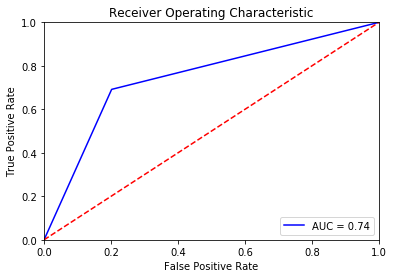

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# compute confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test, predictions.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test, predictions)
print("accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test, predictions, average='micro')
print("precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test, predictions.astype('i4'), average='micro')
print("f1 score: ", f1)


##################################################
# check and plot the ROC curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

             precision    recall  f1-score   support

          0       0.86      0.80      0.83       763
          1       0.59      0.69      0.64       318

avg / total       0.78      0.77      0.77      1081

Confusion matrix, without normalization
[[609 154]
 [ 98 220]]
Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.31  0.69]]


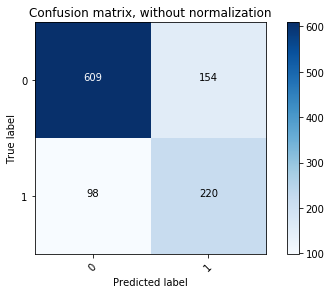

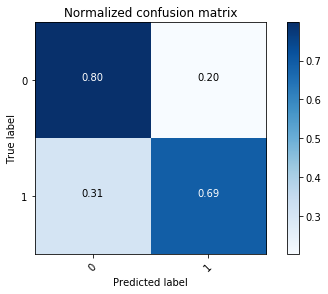

In [19]:
from sklearn.metrics import classification_report
import itertools

# prit classification report 
print(classification_report(y_test, predictions))

class_names = dataset["Class"].unique()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Conclusions
